# Conditional-Like Execution and Masking

This tutorial used to show two approaches to utilizing arithmetic expressions in DALI to achieve conditional results. 

DALI supports conditional execution allowing to run operations conditionally on selected samples using ``if`` statements and scalar conditions, which is now the recommended approach. Using proper conditional execution is both more performant and memory effective. You can read more about it in the [conditional execution section](../../../pipeline.html#conditional-execution) of the Pipeline documentation or in the [conditionals tutorial](../conditionals.html). This approach replaces the one that could previously be emulated by arithmetic operations.

If the conditions have more dimensions, we can work with bitwise operations on such data to emulate logical expressions and conditional execution per every pixel or tensor element. In that case all subexpressions need to be evaluated beforehand. We will show such approach in this tutorial - the output image will be generated based on the value of a masks, with a ``bool`` controlling every output pixel.

## Generating Masks with Comparisons and Bitwise Operations

We will use comparison operators to build masks that represent regions where the image has low and high pixel intensities.

First, we will calculate the images that have their brightness adjusted.
Next, we build masks for *dark* and *bright* pixels. A pixel is considered dark if the *brightest* channel is below a certain threshold. Similarly, it's considered bright if the *darkest* of its channels is above a certain threshold. The masks are obtained by calculating the maximum and minimum along the channel dimension and comparing it against low and high threshold values, respectively. We obtain masks with ``bool`` values inside.

We use bitwise `OR` operation to build a mask that represents the union of low and high intensity regions. The values in the mask are boolean, so the bitwise `|`, `&` `^` operations can be used like their logical counterparts in elementwise fashion. 

DALI arithmetic expressions are elementwise and support broadcasting. We can use the multiplication and addition to build the resulting image. The approach is similar to [multiplexing](https://en.wikipedia.org/wiki/Multiplexer).

Even though the masks are 1-channel - with the shape (H, W, 1), and images have 3 channels, with the shape (H, W, 3) we can multiply them thanks to automatic broadcasting of the channel dimension. You can read more about broadcasting in [this section of documentation](../../../math.html#broadcasting).

Multiplying the image by a boolean mask zeroes out the region of the image corresponding to the ``False`` value in the mask. As the masks are disjoint we can combine augmented images by adding them toghether.

Keep in mind that we first had to produce the images brightened and darkened in all pixels - and the result is built by selecting the original, brightened or darkened value from those inputs based on masks - there is no partial execution of any kind involved, as opposed to using conditional execution for individual samples.

In [1]:
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.types import Constant

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def not_(mask):
    """Emulate logical not operation on tensor data."""
    return True ^ mask


def expand_mask(mask):
    """Expand 1-channel mask into image represented with 3 channels for
    the purpose of displaying it."""
    return fn.cat(mask, mask, mask, axis=2)


@pipeline_def(batch_size=5, num_threads=1, device_id=0)
def masking_pipe():
    input_buf, _ = fn.readers.file(
        device="cpu",
        file_root="../../data/images",
        file_list="../../data/images/file_list.txt",
    )
    imgs = fn.decoders.image(input_buf, device="cpu", output_type=types.RGB)

    imgs_gray = fn.color_space_conversion(
        imgs, image_type=types.RGB, output_type=types.GRAY
    )
    imgs_bright = fn.brightness_contrast(imgs, brightness=3)
    imgs_dark = fn.brightness_contrast(imgs, brightness=0.75)

    mask_low = fn.reductions.max(imgs_gray, axes=-1, keep_dims=True) < 30
    mask_high = fn.reductions.min(imgs_gray, axes=-1, keep_dims=True) > 230

    mask_other = not_(mask_low | mask_high)

    out = mask_low * imgs_bright + mask_high * imgs_dark + mask_other * imgs

    return out, imgs, expand_mask(mask_other * Constant(255).uint8())

In [3]:
mask_pipe = masking_pipe()
mask_pipe.build()

Let's display the resulting images: the augmented and original ones as well as the mask which is black in the areas of adjusted brightness.

In [4]:
def display(augmented, reference, mask, cpu=True):
    data_idx = 0
    fig, axes = plt.subplots(len(augmented), 3, figsize=(15, 15))
    for i in range(len(augmented)):
        img = augmented.at(i) if cpu else augmented.as_cpu().at(i)
        ref = reference.at(i) if cpu else reference.as_cpu().at(i)
        m = mask.at(i) if cpu else mask.as_cpu().at(i)
        axes[i, 0].imshow(np.squeeze(img))
        axes[i, 1].imshow(np.squeeze(ref))
        axes[i, 2].imshow(np.squeeze(m))
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
        axes[i, 2].axis("off")
        axes[i, 0].set_title("Augmented image")
        axes[i, 1].set_title("Reference decoded image")
        axes[i, 2].set_title("Calculated mask")

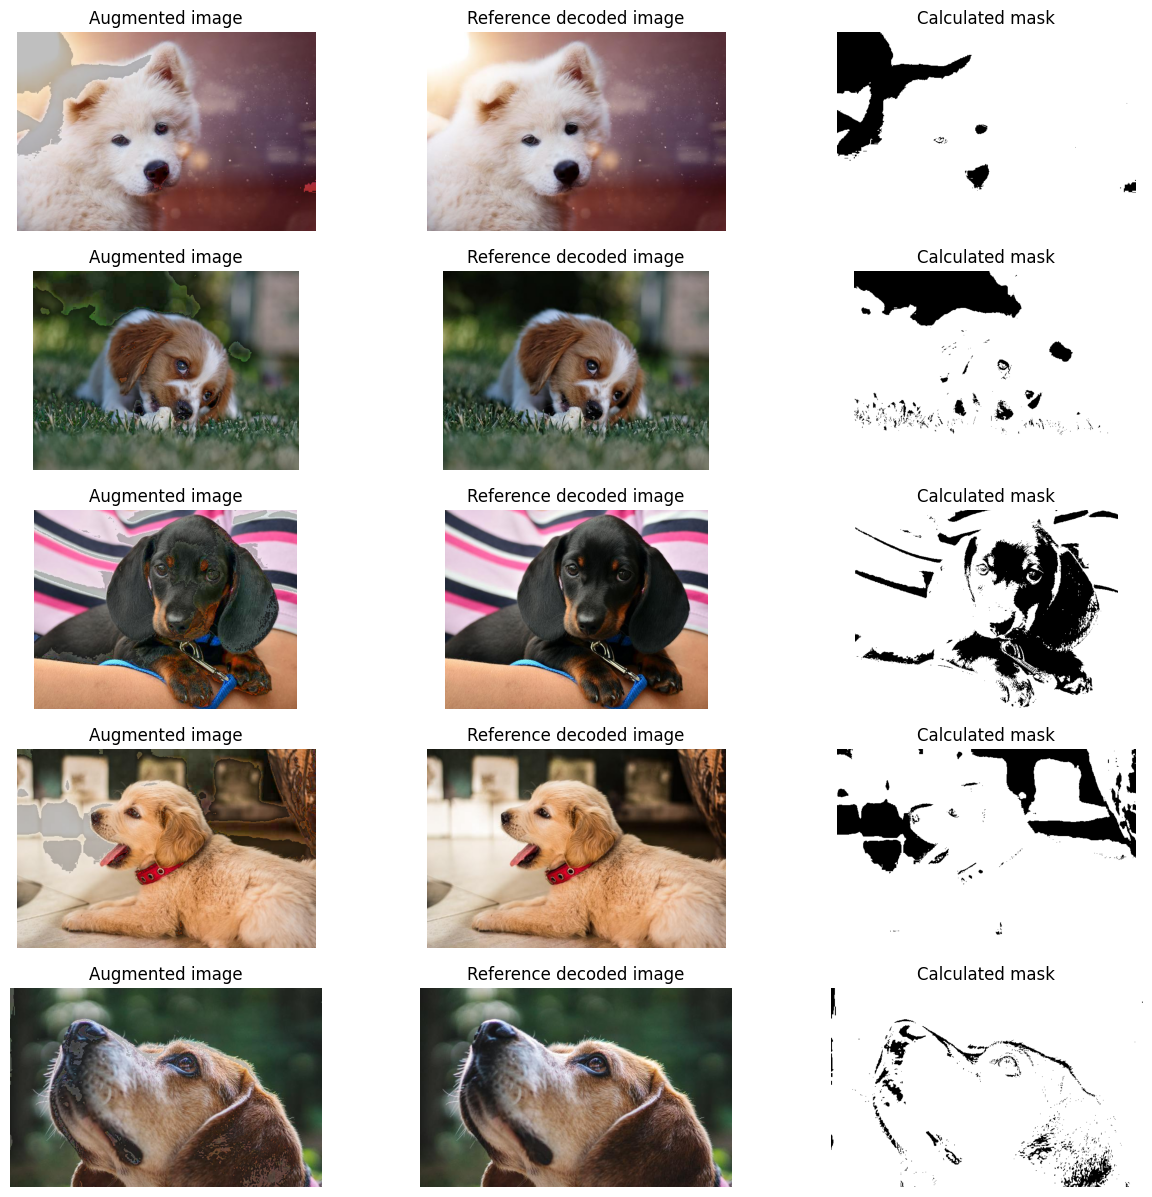

In [5]:
output, reference, mask = mask_pipe.run()
display(output, reference, mask)